self todo: ##

 Manage and Document the Project
- Ensure all Jupyter notebook cells are executed before submission.
- Explain all steps, choices, and reasoning.
- Document dataset selection, preprocessing, and analysis challenges.
- Include descriptions of data sources and installation instructions in an `install_data.txt` file if required.
- Submit a ZIP file with the notebook, required data, and documentation.

## 8. Collaboration and Workflow
- Document contributions of each member.

# Overview

* 1. Ask Interesting Questions
* 2. Get the Data
* 3. Preprocessing the Data
* 4. Explore the Data
* 5. Model the Data
* 6. Communicate and Visualize the Results / Is the Question answered? Why?



## 1. Ask Interesting Questions


#### Our 4 Starting Question we decided to change to a single one:

1. How well can the level of corruption in a European country be quantified?

This questions is too broad and may lack specificity. Also not a good question to answer within a notebook.
The definition of "quantified" needs clarification—are we looking at an index, a model, or a metric?

2. Are there different forms of corruption prevalent in different European countries?

While interesting, it may be challenging to obtain granular, comparable data across countries.
Requires deep qualitative insights, which may not be fully captured by available datasets.

3. What characteristics of a country predict the level of corruption?

Why it's promising:

Allows for quantitative analysis using regression or classification models.
Can leverage socio-economic, political, and governance indicators.
Provides actionable insights for policymakers and organizations.
Well-defined and measurable through publicly available datasets.
Potential Challenges:

Ensuring data quality and avoiding biases in reporting.
Distinguishing correlation from causation.

4. What characteristics of a country predict an increase or decrease in the level of corruption?

Why it's promising:

Focuses on change over time, enabling trend analysis.
Useful for policy evaluation and forecasting.
Encourages a deeper exploration of temporal datasets (e.g., economic reforms, governance improvements, etc.).
Can help identify early warning signs for rising corruption.
Potential Challenges:

Requires time-series data and careful handling of lag effects.
External factors (global economic crises, political events) may introduce noise.


The following question seems the most promising and we decided to only choose this one:

# Main Question: "What characteristics of a european country predict the level of corruption?"

Why it's promising:

Allows for quantitative analysis using regression or classification models.
Can leverage socio-economic, political, and governance indicators.
Provides actionable insights for policymakers and organizations.
Well-defined and measurable through publicly available datasets.
Potential Challenges:

Ensuring data quality and avoiding biases in reporting.
Distinguishing correlation from causation.

maybe we could tackle this one but lets find out later: Which country characteristics (e.g., economic, political, social indicators) best predict the level of corruption in European countries, and how do these characteristics relate to any gap between actual and perceived corruption?



## 2. Get the Data

As we have decided to focus on the continent of europe the first challenge will be to create a dataset of all european countries. To make this notebook not substantially long we will provide the finished data **europe_countries** to you. It shows all european countries and their ISO3 Code and ISO2 Code which should allow better preprocessing later.

In [461]:
import numpy as np
import pandas as pd
import os
import glob
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
# Sklearn libraries for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [418]:
countries = pd.read_csv("../data/processed/europe_countries.csv")
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    49 non-null     object
 1   ISO3 Code  49 non-null     object
 2   ISO2 Code  49 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


When looking at european countrie numbers, many figures fly arround, our data includes 48 countries, and of course the most promising ones. As we will see later most of the other datasets aint serve data for all countries anyway. Especially for small countries like Vatican or Monaco, etc.

Why the Corruption Perceptions Index (CPI) Dataset is a Strong Core for Our Project

The Corruption Perceptions Index (CPI) from Transparency International serves as an excellent core dataset for analyzing the factors influencing corruption in European countries. Below are the key reasons why this dataset is well-suited for our project:

Comprehensive and Reliable Data Source:
Credibility: Transparency International is a globally recognized authority on corruption-related data, ensuring the dataset's legitimacy and accuracy.
Standardized Methodology: The CPI is calculated using multiple expert assessments and business surveys, making it a robust and widely accepted measure of perceived corruption.
Consistency: The data is available annually from 2012 to 2023, providing a solid historical basis for trend analysis and predictions.

### Corruption Perceptions Index (CPI) from Transparency International.
Data Set that shows preceived corruption of countries and rank them.

Link to data: https://images.transparencycdn.org/images/CPI2023_FullDataSet.zip
https://www.transparency.org/en/news/how-cpi-scores-are-calculated

 0   Economy ISO3                                
 1   Economy Name                                 
 2   Year                                           
 3   Corruption Perceptions Index Rank            
 4   Corruption Perceptions Index Score           
 5   Corruption Perceptions Index Sources        
 6   Corruption Perceptions Index Standard Error

We took the xlsx and transformed it to this more comapct version with only features we need and only european countries. Data points get explained at the end of each processing.

In [485]:
cpi_data = pd.read_csv("../data/processed/CPI.csv")

iso3_europe_full = set(countries["ISO3 Code"])

iso3_europe_cpi = set(cpi_data["Economy ISO3"])

print('Lenght of all europe countries in our list: ',len(iso3_europe_full))
print('Lenght of cpi countriest:', len(iso3_europe_cpi))

print('Countries mssing')

missing_countries = iso3_europe_full - iso3_europe_cpi
print('Countries missing:', missing_countries)

Lenght of all europe countries in our list:  42
Lenght of cpi countriest: 42
Countries mssing
Countries missing: set()


Countries missing: Andora, Liechtenstein, Kosovo, San Marino, Vatikan, Gibraltar, Azerbaijan. We could neclect this countries due to their small size and impact.

As they are missing in our main dataset lets exclude them from the countries list

In [486]:
# Filter out missing countries from the 'countries' DataFrame
countries = countries[~countries["ISO3 Code"].isin(missing_countries)]

# Save the filtered DataFrame if needed
countries.to_csv("../data/processed/europe_countries_filtered.csv", index=False)


countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 0 to 47
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    42 non-null     object
 1   ISO3 Code  42 non-null     object
 2   ISO2 Code  42 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [488]:
cpi_data.rename(columns={'Economy ISO3': 'ISO3 Code', 'Economy Name': 'Country'}, inplace=True)

In [490]:
cpi_data.to_csv('../data/processed/cpi_final.csv')

#### CPI Dataset Summary
* Corruption Perceptions Index Rank (float64):
This represents the ranking of the country based on its Corruption Perceptions Index (CPI) score, with rank 1 being the least corrupt country.
Lower ranks indicate better perceived transparency.

* Corruption Perceptions Index Score (float64):
This score quantifies perceived corruption levels on a scale of 0 to 100, where:
0 = highly corrupt
100 = very clean (low corruption perception)
It is calculated using multiple data sources, standardized, and aggregated.

* Corruption Perceptions Index Sources (float64):
The number of sources used to calculate the CPI score for a given country.
The CPI uses multiple expert assessments and business surveys; having more sources increases reliability.

*  Corruption Perceptions Index Standard Error (float64):
This represents the uncertainty or variability in the CPI score, showing how much variation exists among different data sources.
A lower standard error indicates a more reliable score, while a higher one suggests more disagreement or variability in corruption perceptions across sources.

### Processign the World Bank Indicators and form one single wpi dataset via functions and loops

#### Function to filter the datasets on our european country list.

In [462]:
def get_countries(df, countries_df, iso="ISO3 Code", iso_df="Country Code"):
    try:
        
        df.rename(columns={iso_df: iso}, inplace=True)

        
        if iso not in countries_df.columns:
            raise KeyError(f"Column '{iso}' not found in countries DataFrame")
        
        # Process the ISO codes and clean whitespace
        iso_europe = set(countries_df[iso].dropna().astype(str).str.strip())
        iso_data = set(df[iso].dropna().astype(str).str.strip())
        
        # Print missing countries for debugging
        missing_countries = iso_data - iso_europe
        if missing_countries:
            print("Missing countries:", missing_countries)
        
        # Filter the DataFrame based on valid ISO codes
        filtered_df = df[df[iso].isin(iso_europe)]
        
        return filtered_df
    
    except KeyError as err:
        print(f"KeyError: {err}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


#### Conversion of the raw csv to a comprimised Data Frame

In [463]:
def convert_worldbank_df(df, value_name):
    
    df =df.drop(labels=["Series Code", "Series Name"], axis= 1)

    #df = df.drop(df.tail(8).index)

    df.columns = df.columns.str.replace(r"\[.*?\]", "", regex=True).str.strip()
    
    df = df.melt(
    id_vars=['Country Name', 'ISO3 Code'],
    var_name='Year',
    value_name=value_name
)
    
    df.reset_index(drop=True, inplace=True)

    
    return df

#### Loop to combine the indicators of world bank (This session is really only the creation of our world bank df)

So as the process would be the same for every dataset of the worldbank we created a loop and combined the end results to have a better overview in the code. You will find a overall description of every data point after the code.

In [464]:
# Define your datasets info
datasets_info = {
    "rule_of_law": {
        "file_path": "rule_of_law",
        "value_name": "Rule_of_law"
    },
    "government_effectiveness": {
        "file_path": "government_effectiveness",
        "value_name": "Gov_effectiveness"
    },
    "control_of_corruption": {
        "file_path": "control_of_corruption",
        "value_name": "Control_of_corruption"
    },
    "fdi": {
        "file_path": "fdi",
        "value_name": "Fdi"
    },
    "gdp_per_capita": {
        "file_path": "gdp_per_capita",
        "value_name": "Gdp_per_capita"
    },
    "gini": {
        "file_path": "gini",
        "value_name": "Gini"
    },
    "unemployement": {
        "file_path": "unemployement",
        "value_name": "Unemployement"
    },
      "political_stability": {
        "file_path": "political_stability",
        "value_name": "Political_stability"
    },
}


In [465]:
def process_dataset(file_path, value_name, countries_df=countries):
    """
    Reads a CSV file and processes it into a standardized format:
      - Reads the CSV
      - Converts it using 'convert_worldbank_df' (user-defined)
      - Matches and filters countries using 'get_countries' (user-defined)
      - Keeps only [Country Name, Country Code, Year, <value_name>]

    Parameters:
        file_path (str): Path to the CSV file (without the .csv extension).
        value_name (str): Name to be assigned to the indicator value column.
        countries_df (pd.DataFrame): A DataFrame containing valid country information
                                     for filtering/mapping.

    Returns:
        pd.DataFrame: Processed DataFrame with columns:
                      ['Country Name', 'Country Code', 'Year', <value_name>]
    """
    full_path = f'../data/raw/{file_path}.csv'
    
    # Check if file exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"File not found: {full_path}")
    
    # Read CSV
    df = pd.read_csv(full_path)
    
    df.rename(columns={'Country Code': 'ISO3 Code'}, inplace=True)

        
    # Convert the World Bank style data to a long format with 'Year' and 'value_name'
    df = convert_worldbank_df(df=df, value_name=value_name)
    
    # Filter/match country codes and names with european country list
    df = get_countries(df=df, countries_df=countries_df)


    df = df[['ISO3 Code', 'Year', value_name]]
    
    print(df.shape)
    
    return df

In [466]:
def combine_datasets(datasets_info, countries_df):
    """
    Iterates over all datasets in datasets_info, processes each one,
    and merges them into a single DataFrame on ['Country Code', 'Year'].

    Parameters:
        datasets_info (dict): Dictionary containing dataset info with keys like:
                              {
                                  "rule_of_law": {
                                      "file_path": "rule_of_law",
                                      "value_name": "Rule_of_law"
                                  },
                                  ... 
                              }
        countries_df (pd.DataFrame): A DataFrame containing valid country information.

    Returns:
        pd.DataFrame: Final merged DataFrame with columns:
                      ['Country Code', 'Year', <all value_names>]
    """
    merged_df = None

    for ds_name, info in datasets_info.items():
        file_path = info["file_path"]
        value_name = info["value_name"]
        
        try:
            # Process each dataset
            temp_df = process_dataset(
                file_path=file_path,
                value_name=value_name,
            )
            print(f"Successfully processed: {ds_name}")

            # Ensure only necessary columns are present
            temp_df = temp_df[['ISO3 Code', 'Year', value_name]]
            
            # Merge into our final DF
            if merged_df is None:
                merged_df = temp_df
            else:
                merged_df = pd.merge(
                    merged_df,
                    temp_df,
                    on=['ISO3 Code', 'Year'],
                    how='outer'
                )

        except Exception as e:
            print(f"Error processing {ds_name}: {e}")
            continue

    if merged_df is not None:
        # Merge with the reference countries DataFrame to ensure all countries are included
        merged_df = pd.merge(countries_df[['ISO3 Code']], merged_df, on='ISO3 Code', how='left')
        merged_df.sort_values(by=['ISO3 Code', 'Year'], inplace=True)
        merged_df.reset_index(drop=True, inplace=True)

    return merged_df


In [467]:
# Combine them all
world_bank = combine_datasets(datasets_info, countries_df=countries)

# Inspect the merged DataFrame
print(world_bank.head())
print(world_bank.columns)

Missing countries: {'GRL', 'SMR', 'AND', 'TJK', 'LIE', 'KAZ', 'XKX', 'UZB', 'KGZ', 'TKM', 'ARM', 'AZE', 'MCO', 'JEY'}
(504, 3)
Successfully processed: rule_of_law
Missing countries: {'GRL', 'SMR', 'AND', 'TJK', 'LIE', 'KAZ', 'XKX', 'UZB', 'KGZ', 'TKM', 'ARM', 'AZE', 'MCO', 'JEY'}
(504, 3)
Successfully processed: government_effectiveness
Missing countries: {'GRL', 'SMR', 'AND', 'TJK', 'LIE', 'KAZ', 'XKX', 'UZB', 'KGZ', 'TKM', 'ARM', 'AZE', 'MCO', 'JEY'}
(504, 3)
Successfully processed: control_of_corruption
Missing countries: {'GRL', 'SMR', 'CHI', 'AND', 'TJK', 'KAZ', 'XKX', 'UZB', 'KGZ', 'FRO', 'GIB', 'TKM', 'ARM', 'AZE', 'MCO', 'IMN', 'LIE'}
(504, 3)
Successfully processed: fdi
Missing countries: {'AND', 'SMR', 'XKX', 'GIB', 'AZE', '(Europe)', 'MCO', 'LIE'}
(504, 3)
Successfully processed: gdp_per_capita
Missing countries: {'EGY', 'ISR', 'QAT', 'NCL', 'RWA', 'SGP', 'PSE', 'URY', 'IDN', 'MUS', 'BHR', 'JAM', 'LKA', 'PLW', 'NPL', 'PYF', 'ARG', 'KIR', 'DMA', 'LCA', 'ZMB', 'KGZ', 'SOM', 'G

In [468]:
world_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ISO3 Code              504 non-null    object 
 1   Year                   504 non-null    object 
 2   Rule_of_law            504 non-null    float64
 3   Gov_effectiveness      504 non-null    float64
 4   Control_of_corruption  504 non-null    float64
 5   Fdi                    504 non-null    float64
 6   Gdp_per_capita         504 non-null    float64
 7   Gini                   388 non-null    float64
 8   Unemployement          494 non-null    float64
 9   Political_stability    504 non-null    float64
dtypes: float64(8), object(2)
memory usage: 39.5+ KB


In [469]:
world_bank.head(20)

,ISO3 Code,Year,Rule_of_law,Gov_effectiveness,Control_of_corruption,Fdi,Gdp_per_capita,Gini,Unemployement,Political_stability
0,ALB,2012,-0.519840,-0.268925,-0.778729,7.451355,4247.631343,29.0,13.376,-0.143632
1,ALB,2013,-0.518829,-0.324457,-0.751373,9.816285,4413.063383,NaN,15.866,0.091930
2,ALB,2014,-0.311199,-0.049771,-0.586572,8.693039,4578.633208,34.6,18.055,0.485986
3,ALB,2015,-0.319687,0.027575,-0.545141,8.690534,3952.803574,32.8,17.193,0.341639
4,ALB,2016,-0.322632,0.029082,-0.472374,8.805092,4124.055390,33.7,15.418,0.337448
5,ALB,2017,-0.414192,0.098553,-0.481387,7.855448,4531.032207,33.1,13.616,0.373771
6,ALB,2018,-0.414752,0.080525,-0.546019,7.831091,5365.489347,30.1,12.304,0.366779
7,ALB,2019,-0.426317,-0.062301,-0.564274,7.706218,5460.428237,30.1,11.466,0.110105
8,ALB,2020,-0.378028,-0.155121,-0.573539,7.018652,5370.778623,29.4,NaN,0.088613
9,ALB,2021,-0.280716,-0.035985,-0.577180,6.757907,6413.283286,NaN,NaN,0.196372


**We fill the missing values with the medain by country and feature, why?**  
- If a country is generally lower/higher in a particular measure (e.g., GDP), using that country’s own median respects its scale.  
- A global median might be very misleading if the country systematically differs from the overall dataset.


In [476]:
def impute_by_country_and_global_median(df, country_col="iso3_code"):
    """
    Impute missing numeric values in a DataFrame by first using each country's median,
    then falling back to the global median if an entire country-column combination is all missing.
    """
    import numpy as np

    ##Identify float columns
    float_cols = df.select_dtypes(include=[np.float64]).columns

    #Group-based median fill: for each country, fill missing with that country's median
    df[float_cols] = (
        df.groupby(country_col)[float_cols]
          .transform(lambda grp: grp.fillna(grp.median()))
    )

    # 3. Global median fallback: if a country had no non-missing values at all
    for col in float_cols:
        # Check which rows still have NaN in this column
        missing_mask = df[col].isna()
        if missing_mask.any():
            # Get the unique countries still missing for this column
            missing_countries = df.loc[missing_mask, country_col].unique()
            # Print a warning for each country-feature combination
            for c in missing_countries:
                print(f"[WARNING] Column '{col}' for country '{c}' remains missing after group-based fill. "
                      "Falling back to global median.")
            # Fill with global median
            global_median = df[col].median()
            df.loc[missing_mask, col] = global_median

    return df


In [477]:
world_bank = impute_by_country_and_global_median(world_bank, country_col="ISO3 Code")



In [474]:
world_bank[world_bank["Gini"].isna()]

,ISO3 Code,Year,Rule_of_law,Gov_effectiveness,Control_of_corruption,Fdi,Gdp_per_capita,Gini,Unemployement,Political_stability


It looks like only Bosnia and Herzegovina (BIH) has missing values for `gini`, and presumably **all** of those `gini` values are missing within BIH’s group. If a group is entirely missing for a feature, then the group-based median is also `NaN`. Therefore, we need a two-step approach:


In [454]:
world_bank.to_csv("../data/processed/world_bank_final.csv")

## Worldbank Data Indicators

### 1. Basic Information

- **Data Source**: [https://databank.worldbank.org/indicator/NY.GDP.PCAP.CD/1ff4a498/Popular-Indicators?l=en#advancedDownloadOptions](https://databank.worldbank.org/indicator/NY.GDP.PCAP.CD/1ff4a498/Popular-Indicators?l=en#advancedDownloadOptions)
- **Description**: The dataset contains various economic indicators such as GDP per capita, foreign direct investment (FDI), unemployment rates, and governance indicators for European countries from 2012 to 2023.
- **Year/Coverage**: 2012-2023

### 2. Key Variables / Columns

| **Column Name**         | **Type** | **Description**                                                                          |
| ----------------------- | -------- | ---------------------------------------------------------------------------------------- |
| ISO3 Code               | object   | ISO 3 code of the country                                                                |
| Year                    | object   | Year of the recorded value                                                               |
| Rule\_of\_law           | float64  | Measures confidence in legal systems and contract enforcement (range: -2.5 to 2.5).      |
| Gov\_effectiveness      | float64  | Measures the quality of public services and policy implementation (range: -2.5 to 2.5).  |
| Control\_of\_corruption | float64  | Measures perceptions of corruption in public power (range: -2.5 to 2.5).                 |
| Fdi                     | float64  | Foreign direct investment, net inflows as a percentage of GDP.                           |
| Gdp\_per\_capita        | float64  | GDP per capita adjusted for purchasing power parity (PPP).                               |
| Gini                    | float64  | Gini index measuring income inequality (0 = perfect equality, 100 = perfect inequality). |
| Unemployement           | float64  | Total unemployment as a percentage of the total labor force.                             |

### 3. Data Cleaning / Transformation

- **Original Format**: Wide format with years as columns.
- **Filtering**: Retained only European countries.
- **Columns Kept/Removed**: Dropped unnecessary columns like `Series Code` and `Series Name`.
- **Data Type Conversions**: Converted `Year` to string and numeric columns to `float64`.
- **Handling Missing Values**: Missing values are imputed and grouped on country and feature

### 4. Data Context & Usage

#### GDP per Capita (PPP - Purchasing Power Parity)

- **Definition**: GDP at purchasing power parity (PPP) per capita is the PPP value of all final goods and services produced within an economy in a given year, divided by the mid-year population.
- **Range**: Measured in international dollars, adjusted for cost of living.
- **Note**: Helps compare living standards across countries.

#### Foreign Direct Investment (FDI), net inflows (% of GDP)

- **Definition**: Measures net inflows of investment to acquire a lasting management interest in an enterprise operating in another economy.
- **Range**: Expressed as a percentage of GDP.
- **Note**: Includes equity capital, reinvestment of earnings, and short/long-term capital.
- **Long definition**: Foreign direct investment are the net inflows of investment to acquire a lasting management interest (10 percent or more of voting stock) in an enterprise operating in an economy other than that of the investor. It is the sum of equity capital, reinvestment of earnings, other long-term capital, and short-term capital as shown in the balance of payments. This series shows net inflows (new investment inflows less disinvestment) in the reporting economy from foreign investors, and is divided by GDP.
Source: International Monetary Fund, International Financial Statistics and Balance of Payments databases, World Bank, International Debt Statistics, and World Bank and OECD GDP estimates.

#### Unemployment Rate (% of total labor force)

- **Definition**: Refers to the share of the labor force that is without work but available for and seeking employment.
- **Range**: Expressed as a percentage.
- **Note**: Definitions of labor force and unemployment differ by country.

#### Gini Index

- **Definition**: Measures the extent to which the distribution of income among individuals deviates from a perfectly equal distribution.
- **Range**: 0 represents perfect equality; 100 implies perfect inequality.
- **Note**: A higher Gini index indicates greater inequality.
- **Long definition**: Gini index measures the extent to which the distribution of income (or, in some cases, consumption expenditure) among individuals or households within an economy deviates from a perfectly equal distribution. A Lorenz curve plots the cumulative percentages of total income received against the cumulative number of recipients, starting with the poorest individual or household. The Gini index measures the area between the Lorenz curve and a hypothetical line of absolute equality, expressed as a percentage of the maximum area under the line.

#### Rule of Law

- **Definition**: Captures perceptions of confidence in the legal system, contract enforcement, and likelihood of crime and violence.
- **Range**: -2.5 to 2.5.
- **Note**: Higher values indicate stronger rule of law perceptions.
- **Long definition**: Rule of Law captures perceptions of the extent to which agents have confidence in and abide by the rules of society, and in particular the quality of contract enforcement, property rights, the police, and the courts, as well as the likelihood of crime and violence. Estimate gives the country's score on the aggregate indicator, in units of a standard normal distribution

#### Control of Corruption

- **Definition**: Measures perceptions of how public power is exercised for private gain.
- **Range**: -2.5 to 2.5.
- **Note**: Higher values indicate better control of corruption.
- **Long definition**: Control of Corruption captures perceptions of the extent to which public power is exercised for private gain, including both petty and grand forms of corruption, as well as "capture" of the state by elites and private interests. Estimate gives the country's score on the aggregate indicator, in units of a standard normal distribution.

#### Government Effectiveness

- **Definition**: Measures perceptions of the quality of public services and policy implementation.
- **Range**: -2.5 to 2.5.
- **Note**: Higher values indicate more effective governance.
- **Long definition**: Government Effectiveness captures perceptions of the quality of public services, the quality of the civil service and the degree of its independence from political pressures, the quality of policy formulation and implementation, and the credibility of the government's commitment to such policies.
Estimate gives the country's score on the aggregate indicator, in units of a standard normal distribution, i.e.

#### Political Stability and Absence of Violence/Terrorism: Estimate
- **Definition**: Violence/Terrorism measures perceptions of the likelihood of political instability and/or politically-motivated violence, including terrorism.
- **Range**: -2.5 to 2.5. in units of a standard normal distribution,
- **Note**: Higher values indicate more effective governance.

### World Happiness Report

Adding data from the World Happiness Report (WHR) to our corruption analysis gives us a fresh perspective that goes beyond just looking at economic and governance factors. While datasets like the World Bank’s Control of Corruption Index (CCI) and the Corruption Perceptions Index (CPI) mainly focus on how institutions handle corruption, the WHR brings in social and well-being aspects. This helps us get a more complete picture of how corruption affects people's daily lives and what social factors might be linked to it. Looking at things like happiness, social support, and life satisfaction can give us valuable insights into the broader impacts of corruption and how it might be tackled more effectively.

In [352]:
happiness = pd.read_excel("../data/raw/world_happiness_report.xls")

In [353]:
from fuzzywuzzy import process

def apply_iso3_code(df, countries_df, country_column_df):
    """
    Merges 'df'(with country names in 'country_column_df') against 'countries_df' 
    (with 'Country' and 'ISO3 Code') to add the 'ISO3 Code' column to 'df'.
    Uses fuzzy matching to resolve discrepancies in country names.

    Parameters:
        df (pd.DataFrame): Your original DataFrame with country names.
        countries_df (pd.DataFrame): DataFrame with at least two columns:
                                     - 'Country': textual name of the country
                                     - 'ISO3 Code': ISO3 code (e.g. FRA, DEU, etc.)
        country_column_df (str): Column name in 'df' that contains country names.

    Returns:
        pd.DataFrame: Updated DataFrame that includes the 'ISO3 Code'.
    """

    # Step 1: Print unique country names for debugging
    print("Country names in df:", df[country_column_df].unique())
    print("Country names in countries_df:", countries_df['Country'].unique())

    # Step 2: Apply fuzzy matching to standardize country names
    def match_country_name(country, country_list):
        match, score = process.extractOne(country, country_list)
        if score >= 95:  # Confidence threshold for fuzzy matching
            print(f"Matched: {country} -> {match} (Score: {score})")
            return match
        else:
            return country  # Keep the original name if no good match found

    df[country_column_df] = df[country_column_df].apply(lambda x: match_country_name(x, countries_df['Country'].tolist()))

    # Step 3: Merge on the country name after standardization
    merged = df.merge(
        countries_df[['Country', 'ISO3 Code']],
        how='left',
        left_on=country_column_df,
        right_on='Country'
    )

    # Step 4: Remove rows where ISO3 Code could not be assigned (optional)
    merged = merged[~merged['ISO3 Code'].isna()]

    # Step 5: Drop the redundant 'Country' column after merging
    merged.drop(columns=['Country'], inplace=True)

    return merged


In [354]:
happiness = apply_iso3_code(df=happiness, countries_df=countries, country_column_df="Country name")

Country names in df: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo (Brazzaville)' 'Congo (Kinshasa)'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia' 'Denmark' 'Djibouti'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia' 'Eswatini'
 'Ethiopia' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany'
 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong S.A.R. of China' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Ivory Coast' 'Jamaica' 'Japan'
 'Jordan' 'Kazakhstan' 'Kenya' 'Kosovo' 'Kuwait' 'Kyrgyzstan' 'Laos'
 'Latvia' 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Lithuania' 'Luxembourg'
 'Ma

In [355]:
happiness.rename(columns={'year': 'Year'}, inplace=True)

In [356]:
happiness = happiness.sort_values(by=["Country name", "Year"])
happiness.reset_index(drop=True, inplace=True)
happiness = happiness[happiness['Year'] >= 2012]

In [357]:
happiness = happiness.drop(axis=1, labels=['Perceptions of corruption', 'Log GDP per capita'])

In [458]:
happiness.head()

,year,life_ladder,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,positive_affect,negative_affect,iso3_code
4,2012,5.510124,0.784502,68.160004,0.601512,-0.172988,0.553473,0.271393,ALB
5,2013,4.550648,0.759477,68.440002,0.631830,-0.131339,0.540751,0.338379,ALB
6,2014,4.813763,0.625587,68.720001,0.734648,-0.028801,0.572945,0.334543,ALB
7,2015,4.606651,0.639356,69.000000,0.703851,-0.084982,0.579072,0.350427,ALB
8,2016,4.511101,0.638411,69.025002,0.729819,-0.021136,0.567080,0.321706,ALB


In [457]:
happiness.to_csv('../data/processed/happines_final.csv')

Getting the Report From World Happiness Report: https://worldhappiness.report/data/


- **Life Ladder**  
  - **Description:** A measure of subjective well-being based on the Cantril ladder, where respondents rate their life satisfaction on a scale from 0 to 10.  
  - **Technical Methodology:** Survey respondents rate their current life relative to their “best possible” and “worst possible” life. The national average is computed from individual responses.  
  - **Range:** 0 to 10.

- **Social support**  
  - **Description:** Perceived availability of social connections and support from friends and family during difficult times.  
  - **Technical Methodology:** Based on the percentage of respondents who report having someone to rely on in times of need.  
  - **Range:** 0 to 1 (proportion of respondents).

- **Healthy life expectancy at birth**  
  - **Description:** The average number of years a newborn is expected to live in good health.  
  - **Technical Methodology:** Derived from the World Health Organization (WHO) life tables and estimates. It accounts for mortality rates and morbidity data.  
  - **Range:** Typically between 50 to 85 years.

- **Freedom to make life choices**  
  - **Description:** The perception of personal freedom to make life choices.  
  - **Technical Methodology:** Based on survey questions where respondents report their level of freedom in decision-making. The national average is calculated.  
  - **Range:** 0 to 1 (proportion of positive responses).

- **Generosity**  
  - **Description:** The level of charitable behavior and generosity among the population.  
  - **Technical Methodology:** Based on self-reported recent donations and willingness to help strangers. The score is adjusted for income differences across countries.  
  - **Range:** Typically between -0.2 to 0.8 (due to standardization).

- **Positive affect**  
  - **Description:** The frequency of experiencing positive emotions such as laughter, joy, and enjoyment.  
  - **Technical Methodology:** Measured through survey questions where respondents report their experiences of positive emotions over the previous day.  
  - **Range:** 0 to 1 (proportion of positive responses).

- **Negative affect**  
  - **Description:** The frequency of experiencing negative emotions such as worry, sadness, and anger.  
  - **Technical Methodology:** Measured through survey questions where respondents report their experiences of negative emotions over the previous day.  
  - **Range:** 0 to 1 (proportion of negative responses).

### UN Data

Source : https://dataunodc.un.org/dp-crime-corruption-offences <br>
Variables : https://dataunodc.un.org/sites/dataunodc.un.org/files/metadata_corruption_and_economic_crime.pdf <br>
Measurement unit: Rate per 100,000 population (R𝑎𝑡𝑒 = 100,000∗ 𝑂𝑓𝑓𝑒𝑛𝑐𝑒𝑠/ 𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜n)<br>
Countries: Used the same that were in the notebook joined_data
<br>
<br>
Corruption -> Unlawful acts as defined in the United Nations Convention against Corruption and other national and international legal instruments against corruption. <br>
<br>
Corruption: Bribery ->  Promising, offering, giving, soliciting, or accepting an undue advantage to or from a public official or a person who directs or works in a private sector entity, directly or indirectly, in order that the person act or refrain from acting in the exercise of his or her official duties<br>
<br>
Corruption: Other acts of corruption ->  Other acts of corruption includes embezzlement, abuse of functions, trading in influence, illicit enrichment and all other acts of corruption not mentioned above. <br>
<br>
Fraud -> Conversion or transfer of property, knowing that such property is the proceeds of crime, for the purpose of concealing or disguising the illicit origin of such property or of helping any person who is involved in the commission of the predicate offence to evade the legal  consequences of his or her actions, as well as the concealment or disguise of the true nature, source, location, disposition, movement or ownership of rights with respect to the property.<br>
<br>
Money laundering -> Conversion or transfer of property, knowing that such property is the proceeds of crime, for the purpose of concealing or disguising the illicit origin of such property or of helping any person who is involved in the commission of the predicate offence to evade the legal consequences of his or her actions, as well as the concealment or disguise of the true nature, source, location, disposition, movement or ownership of rights with respect to the property.<br>


In [359]:
# Load and preprocess data
un_data = pd.read_excel("../data/raw/un_corruption.xlsx")
un_data.columns = un_data.iloc[1]
un_data = un_data[2:].reset_index(drop=True)

# Convert data types
un_data["year"] = pd.to_numeric(un_data["Year"])
un_data["VALUE"] = pd.to_numeric(un_data["VALUE"])

# Filter relevant data
un_data = un_data[(un_data['Indicator'] == 'Offences') &
                  (un_data['year'].between(2013, 2023)) &
                  (un_data['Unit of measurement'] == 'Rate per 100,000 population')]

# Drop unnecessary columns
un_data.drop(columns=["Dimension", "Sex", "Age", "Source", "Region", "Indicator", "Year",
                      "Unit of measurement", "Subregion"], inplace=True)

# Standardize country names
country_mapping = {
    'Netherlands (Kingdom of the)': "Netherlands",
    'United Kingdom (England and Wales)': "United Kingdom"
}
un_data["Country"] = un_data["Country"].replace(country_mapping)

# Load mapping data
mapping_data = pd.read_csv('../data/processed/merged_.csv')

# Filter out countries not in mapping data
valid_countries = set(mapping_data['country'])
un_data = un_data[un_data['Country'].isin(valid_countries)].reset_index(drop=True)

# Pivot data for better analysis
un_data = un_data.pivot(index=['Country', 'year'], columns='Category', values='VALUE').reset_index()
un_data.columns.name = None

## change the country name as it wont be recognized by our function
un_data["Country"] = un_data["Country"].replace("Czechia", "Czech Republic")



In [459]:
un_data.head(20)

,year,burglary,corruption,corruption_bribery,corruption_other_acts_of_corruption,fraud,money_laundering,smuggling_of_migrants,theft,theft_of_a_motorized_vehicle,iso3_code
0,2013,12.642821,NaN,NaN,NaN,NaN,NaN,NaN,182.021978,19.812859,ALB
1,2014,10.228487,NaN,NaN,NaN,NaN,NaN,NaN,276.030459,13.903808,ALB
2,2015,8.013930,35.906568,7.424160,28.482408,25.533559,11.830087,NaN,243.262662,9.609777,ALB
3,2016,NaN,35.820112,8.885609,26.934503,31.689692,12.668935,2.186693,195.795788,10.343405,ALB
4,2017,NaN,40.078420,10.314810,29.763610,35.355140,13.162670,2.118530,176.984082,11.426170,ALB
5,2018,NaN,35.905295,9.523766,26.381528,32.707534,12.200153,4.414301,188.181284,8.759085,ALB
6,2019,NaN,46.278834,10.612815,35.666019,30.411805,13.953242,5.080233,168.169627,11.065165,ALB
7,2020,NaN,29.544632,5.615922,23.928711,27.835439,14.545586,10.603977,110.295310,6.941419,ALB
8,2021,26.132252,34.224142,9.212845,25.011297,32.262471,13.731693,13.626603,117.069685,7.251174,ALB
9,2022,21.355786,41.515367,17.380162,24.135205,34.091857,16.711694,14.706291,86.478621,4.186719,ALB


In [361]:
un_data.drop(columns=[
    'Fraud: Cyber-related (Cy)',
    'Unlawful access to a computer system',
    'Unlawful interception or access of computer data',
    'Unlawful interference with a computer system or computer data'
], inplace=True)

In [362]:
un_data = apply_iso3_code(df=un_data, countries_df=countries, country_column_df="Country")

Country names in df: ['Albania' 'Austria' 'Belarus' 'Belgium' 'Bosnia and Herzegovina'
 'Bulgaria' 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Estonia'
 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Hungary' 'Iceland'
 'Ireland' 'Italy' 'Latvia' 'Lithuania' 'Luxembourg' 'Malta' 'Montenegro'
 'Netherlands' 'North Macedonia' 'Norway' 'Poland' 'Portugal' 'Romania'
 'Serbia' 'Slovenia' 'Spain' 'Sweden' 'Switzerland' 'Ukraine'
 'United Kingdom']
Country names in countries_df: ['Albania' 'Austria' 'Belarus' 'Belgium' 'Bosnia & Herzegovina' 'Bulgaria'
 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Estonia' 'Finland'
 'France' 'Georgia' 'Germany' 'Greece' 'Hungary' 'Iceland' 'Ireland'
 'Italy' 'Latvia' 'Lithuania' 'Luxembourg' 'Malta' 'Moldova' 'Montenegro'
 'Netherlands' 'North Macedonia' 'Norway' 'Poland' 'Portugal' 'Romania'
 'Russia' 'Serbia' 'Slovakia' 'Slovenia' 'Spain' 'Sweden' 'Switzerland'
 'Turkey' 'Ukraine' 'United Kingdom']
Matched: Albania -> Albania (Score: 100)
Matched: A

In [479]:
test = impute_by_country_and_global_median(df=un_data)

In [480]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   year                                 360 non-null    Int64  
 1   burglary                             360 non-null    float64
 2   corruption                           360 non-null    float64
 3   corruption_bribery                   360 non-null    float64
 4   corruption_other_acts_of_corruption  360 non-null    float64
 5   fraud                                360 non-null    float64
 6   money_laundering                     360 non-null    float64
 7   smuggling_of_migrants                360 non-null    float64
 8   theft                                360 non-null    float64
 9   theft_of_a_motorized_vehicle         360 non-null    float64
 10  iso3_code                            360 non-null    object 
dtypes: Int64(1), float64(9), object(

It misses Czech Rebublic so we need to change it manually

#### Why We’re Using (and Questioning) the UNODC Corruption Data

We're considering the **UNODC corruption and economic crime dataset** because it provides **actual reported cases**, unlike Transparency International’s CPI, which is based on perceptions. It covers specific corruption types like **bribery, fraud, and money laundering**, giving us more detailed insights.

##### Pros
- **Objective Data:** Unlike CPI, it's based on real reported cases, not just opinions.
- **Comparability:** Standardized as "per 100,000 population," making cross-country comparisons easier.
- **Detailed Breakdown:** Focus on different types of corruption, which helps with targeted analysis.

##### Cons
- **Underreporting Issues:** Many corruption cases likely go unreported, making data reliability questionable.
- **Legal Differences:** Definitions and enforcement levels vary across countries, affecting consistency.
- **False Comparisons:** Lower numbers don’t always mean less corruption – it could just mean weaker enforcement.


#### Conclusion
It’s useful, but with limitations. We'll need to look further to get a full picture


### Data Summary

| Datapoint                                | Description                                                                                                                                                  | Data Source                                                  |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------|
| Corruption Perceptions Index Rank        | Ranking based on CPI score; lower rank = better transparency.                                                                                                 | Transparency International                                  |
| Corruption Perceptions Index Score       | Score from 0 (highly corrupt) to 100 (very clean).                                                                                                           | Transparency International                                  |
| Corruption Perceptions Index Sources     | Number of sources used to calculate CPI score.                                                                                                               | Transparency International                                  |
| Corruption Perceptions Index Std. Error  | Uncertainty in CPI score; lower values = more reliability.                                                                                                   | Transparency International                                  |
| GDP per Capita (PPP)                      | Economic output per person, adjusted for purchasing power parity.                                                                                             | World Bank                                                  |
| Foreign Direct Investment (% of GDP)     | Measures foreign investment relative to GDP.                                                                                                                 | IMF, World Bank, OECD                                       |
| Unemployment Rate (% of labor force)     | Percentage of labor force without employment but seeking work.                                                                                               | Eurostat, World Bank                                        |
| Gini Index                               | Measures income inequality (0 = perfect equality, 100 = perfect inequality).                                                                                | World Bank                                                  |
| Rule of Law                              | Confidence in legal system, contract enforcement, and crime levels (-2.5 to 2.5).                                                                            | World Bank (WGI)                                            |
| Control of Corruption                    | Public power misuse for private gain (-2.5 to 2.5).                                                                                                          | World Bank (WGI)                                            |
| Government Effectiveness                 | Quality of public services and policy implementation (-2.5 to 2.5).                                                                                          | World Bank (WGI)                                            |
| Political Stability & Absence of Violence| Likelihood of political instability and violence (-2.5 to 2.5).                                                                                              | World Bank (WGI)                                            |
| Life Ladder                              | Subjective well-being rating (0 to 10).                                                                                                                      | World Happiness Report                                      |
| Social Support                           | Availability of social connections in difficult times (0 to 1).                                                                                              | World Happiness Report                                      |
| Healthy Life Expectancy                   | Expected healthy years of life at birth.                                                                                                                     | WHO, World Happiness Report                                 |
| Freedom to Make Life Choices             | Perceived personal freedom to make decisions (0 to 1).                                                                                                       | World Happiness Report                                      |
| Generosity                               | Charitable behavior and willingness to help (standardized -0.2 to 0.8).                                                                                       | World Happiness Report                                      |
| Positive Affect                          | Frequency of experiencing positive emotions (0 to 1).                                                                                                        | World Happiness Report                                      |
| Negative Affect                          | Frequency of experiencing negative emotions (0 to 1).                                                                                                        | World Happiness Report                                      |


## 3. Preprocessing the Data

Before we merge the datasets and preprocess them we will take a look at their shapes and the countries the have included.

In [500]:
world_bank_final = pd.read_csv("../data/processed/world_bank_final.csv", index_col=0)
happiness_final = pd.read_csv("../data/processed/happiness_final.csv", index_col=0)
cpi_final = pd.read_csv("../data/processed/cpi_final.csv", index_col=0)


In [505]:
cpi_final.head()

,iso3_code,country,year,corruption_perceptions_index_rank,corruption_perceptions_index_score,corruption_perceptions_index_sources,corruption_perceptions_index_standard_error
0,ALB,Albania,2012,113.0,33.0,7.0,2.00
1,ALB,Albania,2013,116.0,31.0,7.0,2.10
2,ALB,Albania,2014,110.0,33.0,7.0,1.51
3,ALB,Albania,2015,88.0,36.0,7.0,3.58
4,ALB,Albania,2016,83.0,39.0,7.0,1.99


In [504]:

datasets = {
    'cpi_data': cpi_final,
    'world_bank': world_bank_final,
    'happiness': happiness_final,
    'un_data' : un_data
}

### 3.1 Clean the columns

In [503]:
import re

def clean_datasets(datasets):
    country_keywords = ['country', 'country_name', 'nation', 'state', "countries"]

    for dataset_name, df in datasets.items():
        # Process column names: lowercase, strip spaces, replace spaces/special chars with '_'
        df.columns = (
            df.columns.str.lower()
            .str.strip()
            .str.replace(r'\s+', '_', regex=True)  # Replace spaces with underscores
            .str.replace(r'[^a-z0-9_]', '', regex=True)  # Remove special characters
        )

        # Remove columns related to 'country' unless it's the 'cpi_data' dataset
        if dataset_name != 'cpi_data':
            df.drop(columns=[col for col in df.columns if any(keyword in col for keyword in country_keywords)], inplace=True, errors='ignore')
            
            
        if 'year' in df.columns:
            df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
    

        datasets[dataset_name] = df
        

clean_datasets(datasets)


In [507]:
import pandas as pd

def analyze_datasets(datasets):
    """
    Analyzes the shape of datasets and checks the uniqueness of the 'iso3code' column in cpi_data.

    Parameters:
        datasets (dict): A dictionary containing dataset names as keys and DataFrame objects as values.

    Returns:
        dict: A dictionary with dataset shapes and uniqueness check results.
    """

    
    iso_europe = set(countries["ISO3 Code"].dropna().astype(str).str.strip())


    for name, df in datasets.items():
        # Print dataset shape and columns
        print(f"\n{name}:")
        print(f" - Shape: {df.shape}")
        print(f" - Columns: {df.columns.tolist()}")
        display(df.head())
        print(f"Type of year: {df['year'].dtype}")

        # Check and process 'ISO3 Code' column
        if 'iso3_code' in df.columns:
            iso_codes = set(df['iso3_code'].dropna().astype(str).str.strip())
            missing_countries = iso_europe - iso_codes

            print(f" - Number of unique countries found: {len(iso_codes)}")
            if missing_countries:
                print(f" - Missing countries compared to reference: {missing_countries}")
            else:
                print(" - No missing countries compared to reference.")
        else:
            print(" - Column 'iso3_code' not found in dataset.")


# Run the analysis
analyze_datasets(datasets)





cpi_data:
 - Shape: (504, 7)
 - Columns: ['iso3_code', 'country', 'year', 'corruption_perceptions_index_rank', 'corruption_perceptions_index_score', 'corruption_perceptions_index_sources', 'corruption_perceptions_index_standard_error']


,iso3_code,country,year,corruption_perceptions_index_rank,corruption_perceptions_index_score,corruption_perceptions_index_sources,corruption_perceptions_index_standard_error
0,ALB,Albania,2012,113.0,33.0,7.0,2.00
1,ALB,Albania,2013,116.0,31.0,7.0,2.10
2,ALB,Albania,2014,110.0,33.0,7.0,1.51
3,ALB,Albania,2015,88.0,36.0,7.0,3.58
4,ALB,Albania,2016,83.0,39.0,7.0,1.99


Type of year: Int64
 - Number of unique countries found: 42
 - No missing countries compared to reference.

world_bank:
 - Shape: (504, 10)
 - Columns: ['iso3_code', 'year', 'rule_of_law', 'gov_effectiveness', 'control_of_corruption', 'fdi', 'gdp_per_capita', 'gini', 'unemployement', 'political_stability']


,iso3_code,year,rule_of_law,gov_effectiveness,control_of_corruption,fdi,gdp_per_capita,gini,unemployement,political_stability
0,ALB,2012,-0.519840,-0.268925,-0.778729,7.451355,4247.631343,29.00,13.376,-0.143632
1,ALB,2013,-0.518829,-0.324457,-0.751373,9.816285,4413.063383,31.45,15.866,0.091930
2,ALB,2014,-0.311199,-0.049771,-0.586572,8.693039,4578.633208,34.60,18.055,0.485986
3,ALB,2015,-0.319687,0.027575,-0.545141,8.690534,3952.803574,32.80,17.193,0.341639
4,ALB,2016,-0.322632,0.029082,-0.472374,8.805092,4124.055390,33.70,15.418,0.337448


Type of year: Int64
 - Number of unique countries found: 42
 - No missing countries compared to reference.

happiness:
 - Shape: (469, 9)
 - Columns: ['year', 'life_ladder', 'social_support', 'healthy_life_expectancy_at_birth', 'freedom_to_make_life_choices', 'generosity', 'positive_affect', 'negative_affect', 'iso3_code']


,year,life_ladder,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,positive_affect,negative_affect,iso3_code
4,2012,5.510124,0.784502,68.160004,0.601512,-0.172988,0.553473,0.271393,ALB
5,2013,4.550648,0.759477,68.440002,0.631830,-0.131339,0.540751,0.338379,ALB
6,2014,4.813763,0.625587,68.720001,0.734648,-0.028801,0.572945,0.334543,ALB
7,2015,4.606651,0.639356,69.000000,0.703851,-0.084982,0.579072,0.350427,ALB
8,2016,4.511101,0.638411,69.025002,0.729819,-0.021136,0.567080,0.321706,ALB


Type of year: Int64
 - Number of unique countries found: 40
 - Missing countries compared to reference: {'TUR', 'CZE'}

un_data:
 - Shape: (360, 11)
 - Columns: ['year', 'burglary', 'corruption', 'corruption_bribery', 'corruption_other_acts_of_corruption', 'fraud', 'money_laundering', 'smuggling_of_migrants', 'theft', 'theft_of_a_motorized_vehicle', 'iso3_code']


,year,burglary,corruption,corruption_bribery,corruption_other_acts_of_corruption,fraud,money_laundering,smuggling_of_migrants,theft,theft_of_a_motorized_vehicle,iso3_code
0,2013,12.642821,35.905931,9.368306,26.658016,31.976082,13.447181,5.080233,182.021978,19.812859,ALB
1,2014,10.228487,35.905931,9.368306,26.658016,31.976082,13.447181,5.080233,276.030459,13.903808,ALB
2,2015,8.013930,35.906568,7.424160,28.482408,25.533559,11.830087,5.080233,243.262662,9.609777,ALB
3,2016,12.642821,35.820112,8.885609,26.934503,31.689692,12.668935,2.186693,195.795788,10.343405,ALB
4,2017,12.642821,40.078420,10.314810,29.763610,35.355140,13.162670,2.118530,176.984082,11.426170,ALB


Type of year: Int64
 - Number of unique countries found: 38
 - Missing countries compared to reference: {'MDA', 'SVK', 'TUR', 'RUS'}


### 3.2 Merge The Data

Here we load all explored and preprocessed datasets, to combine them into one large dataset. We also standardize the country_code and year column, as we use it to join the datasets.

In [508]:
merged_df = None

for name, df in datasets.items():
    # Ensure 'iso3_code' and 'year' are in all dataframes
    if 'iso3_code' in df.columns and 'year' in df.columns:
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on=['iso3_code', 'year'], how='outer')
    else:
        print(f"Skipping {name}: required columns missing.")


# Display the final merged dataset
print("\nMerged Dataset:")
print(merged_df)


Merged Dataset:
    iso3_code  country  year  corruption_perceptions_index_rank  \
0         ALB  Albania  2012                              113.0   
1         ALB  Albania  2013                              116.0   
2         ALB  Albania  2014                              110.0   
3         ALB  Albania  2015                               88.0   
4         ALB  Albania  2016                               83.0   
..        ...      ...   ...                                ...   
499       UKR  Ukraine  2019                              126.0   
500       UKR  Ukraine  2020                              117.0   
501       UKR  Ukraine  2021                              122.0   
502       UKR  Ukraine  2022                              116.0   
503       UKR  Ukraine  2023                              104.0   

     corruption_perceptions_index_score  corruption_perceptions_index_sources  \
0                                  33.0                                   7.0   
1               

In [509]:

columns_to_drop = ['corruption_perceptions_index_rank', 'corruption_perceptions_index_sources', 
                   'corruption', 'corruption_bribery', 'corruption_perceptions_index_standard_error', 'corruption_other_acts_of_corruption']

merged_df = merged_df.drop(columns=columns_to_drop)



In [510]:
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   iso3_code                           504 non-null    object 
 1   country                             504 non-null    object 
 2   year                                504 non-null    Int64  
 3   corruption_perceptions_index_score  504 non-null    float64
 4   rule_of_law                         504 non-null    float64
 5   gov_effectiveness                   504 non-null    float64
 6   control_of_corruption               504 non-null    float64
 7   fdi                                 504 non-null    float64
 8   gdp_per_capita                      504 non-null    float64
 9   gini                                504 non-null    float64
 10  unemployement                       504 non-null    float64
 11  political_stability                 504 non-n

In [511]:
merged_df.to_csv('../data/processed/corruption_dataset.csv')

### 3.3 Load combined Dataset and handle missing values

In [512]:
corruption_dataset = pd.read_csv('../data/processed/corruption_dataset.csv', index_col=0)

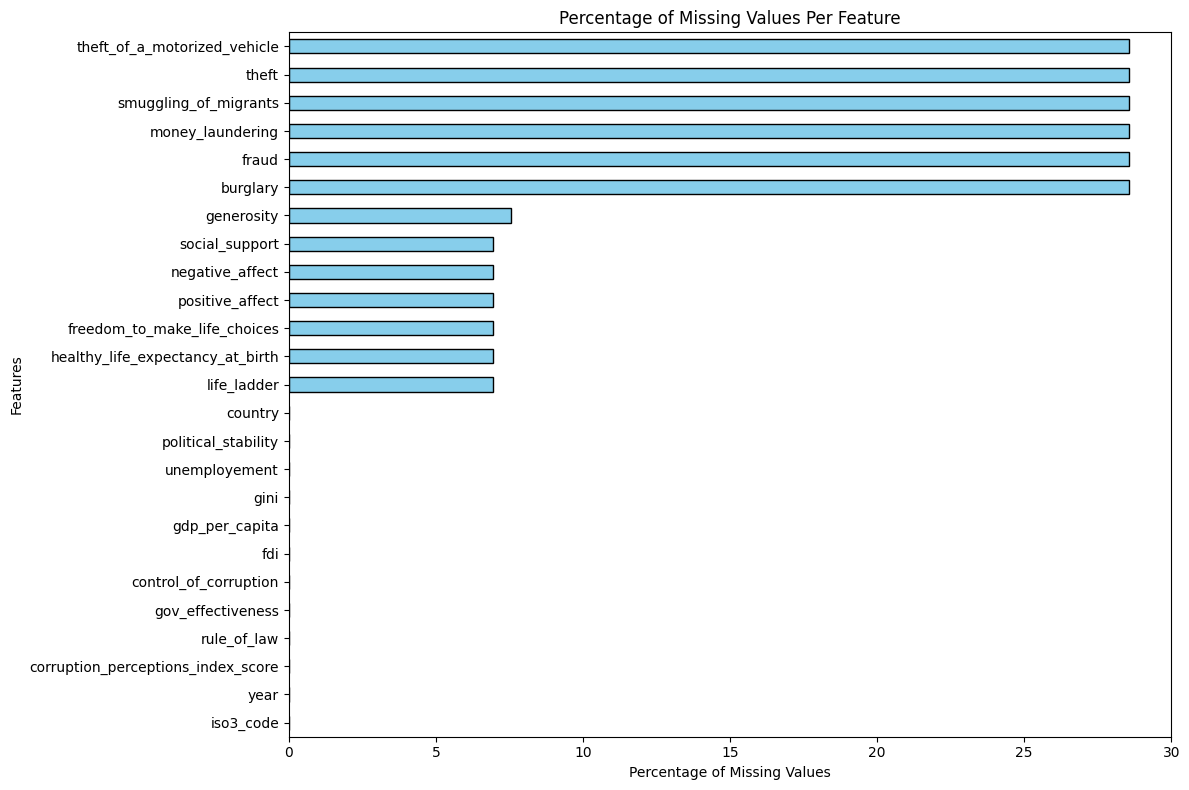

/var/folders/0n/jq4hk2n95c51k_c9nh0xpnrc0000gn/T/ipykernel_65097/2271046860.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_per_year = corruption_dataset.groupby('year').apply(lambda x: x.isnull().sum().sum())


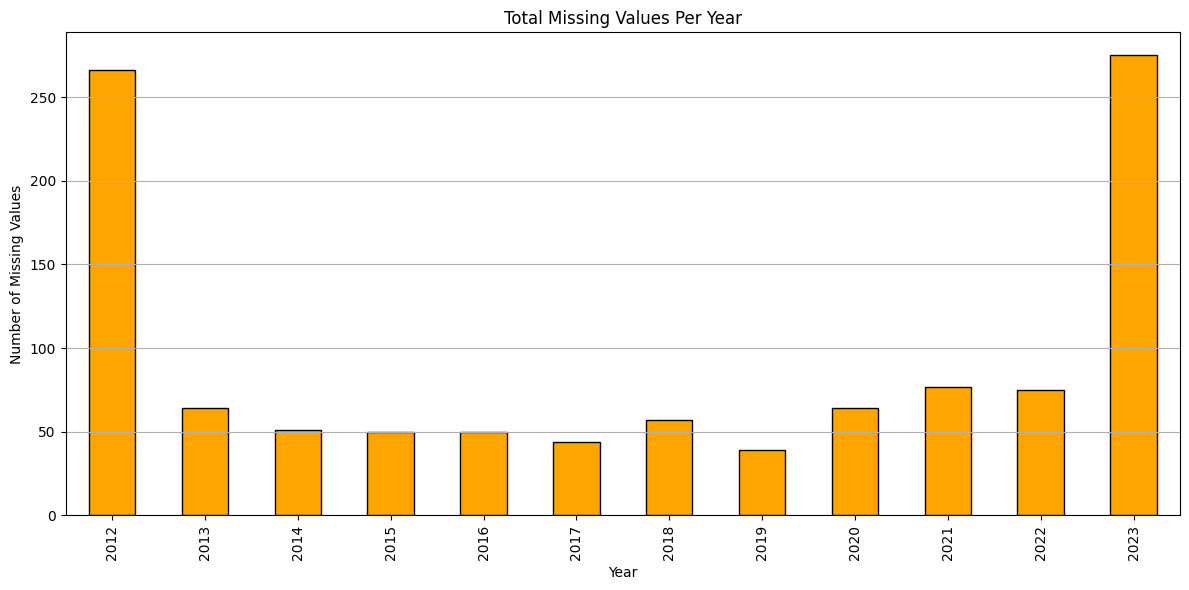

In [513]:

# Missing Values Per Feature
missing_feature_percentage = corruption_dataset.isnull().mean() * 100
sorted_missing_feature_percentage = missing_feature_percentage.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sorted_missing_feature_percentage.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Percentage of Missing Values Per Feature")
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Features")
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert y-axis to show the most missing feature at the top
plt.show()

# Missing Values Per Year
missing_values_per_year = corruption_dataset.groupby('year').apply(lambda x: x.isnull().sum().sum())

plt.figure(figsize=(12, 6))
missing_values_per_year.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Total Missing Values Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Missing Values")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/var/folders/0n/jq4hk2n95c51k_c9nh0xpnrc0000gn/T/ipykernel_65097/3495046378.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_percentage = corruption_dataset.groupby(['country', 'year']).apply(lambda x: x.isnull().sum().sum() / x.size * 100).reset_index()


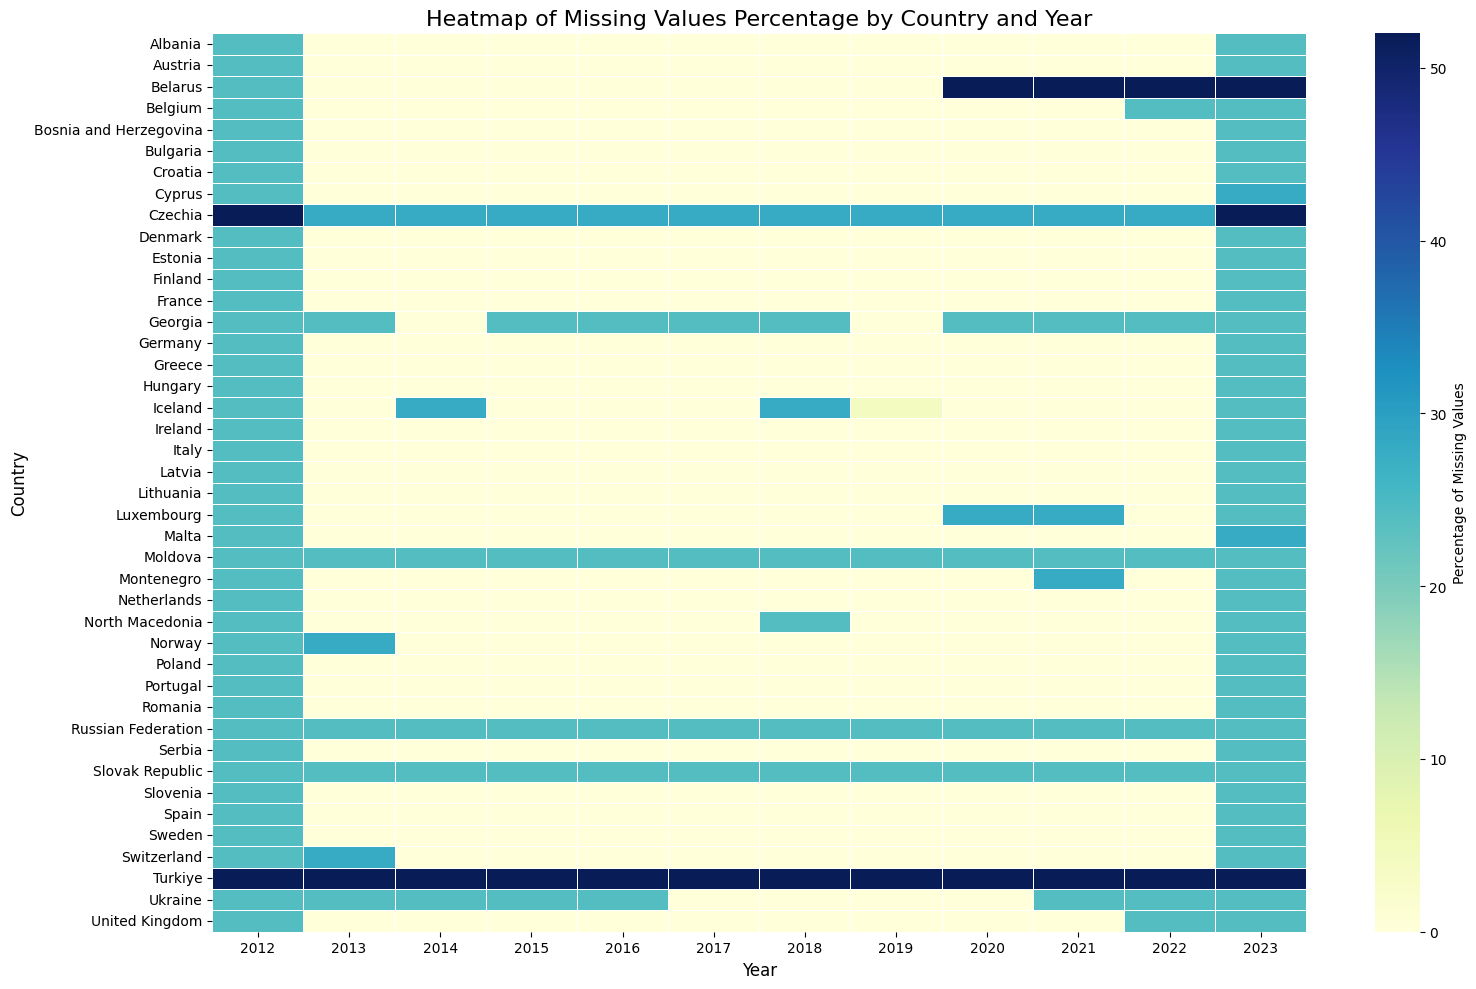

In [514]:
# Calculate the percentage of missing values for each country and year
missing_percentage = corruption_dataset.groupby(['country', 'year']).apply(lambda x: x.isnull().sum().sum() / x.size * 100).reset_index()
missing_percentage.columns = ['country', 'year', 'missing_percentage']

# Pivot the data to create a heatmap-friendly format
heatmap_data = missing_percentage.pivot(index='country', columns='year', values='missing_percentage')

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    cbar_kws={'label': 'Percentage of Missing Values'},
    linewidths=0.5,
    annot=False
)
plt.title('Heatmap of Missing Values Percentage by Country and Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()


## 4. Explore the Data


## 2. INITIAL DATA EXPLORATION

Before modeling, we need to understand the structure of our dataset:
- **Shape** of the dataset (rows & columns).
- **Missing values** per column.
- **Data types** and basic statistics.


In [517]:
# In[2]:
# Basic exploration of the dataset

print("Shape of the dataset:", corruption_dataset.shape)
print("\nColumns in the dataset:", corruption_dataset.columns.tolist())

# Check for missing values
missing_values = corruption_dataset.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Basic descriptive statistics
corruption_dataset.describe(include='all')


Shape of the dataset: (504, 25)

Columns in the dataset: ['iso3_code', 'country', 'year', 'corruption_perceptions_index_score', 'rule_of_law', 'gov_effectiveness', 'control_of_corruption', 'fdi', 'gdp_per_capita', 'gini', 'unemployement', 'political_stability', 'life_ladder', 'social_support', 'healthy_life_expectancy_at_birth', 'freedom_to_make_life_choices', 'generosity', 'positive_affect', 'negative_affect', 'burglary', 'fraud', 'money_laundering', 'smuggling_of_migrants', 'theft', 'theft_of_a_motorized_vehicle']

Missing values per column:
iso3_code                               0
country                                 0
year                                    0
corruption_perceptions_index_score      0
rule_of_law                             0
gov_effectiveness                       0
control_of_corruption                   0
fdi                                     0
gdp_per_capita                          0
gini                                    0
unemployement                 

,iso3_code,country,year,corruption_perceptions_index_score,rule_of_law,gov_effectiveness,control_of_corruption,fdi,gdp_per_capita,gini,...,freedom_to_make_life_choices,generosity,positive_affect,negative_affect,burglary,fraud,money_laundering,smuggling_of_migrants,theft,theft_of_a_motorized_vehicle
count,504,504,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,...,469.000000,466.000000,469.000000,469.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
unique,42,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ALB,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,12,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2017.500000,58.751984,0.753714,0.778765,0.688300,9.862133,31410.242198,31.720238,...,0.783371,-0.015073,0.644233,0.251419,351.951016,334.536464,8.774683,4.457181,1105.819120,82.177258
std,NaN,NaN,3.455482,17.892322,0.870846,0.783930,0.964294,46.050954,26942.426314,4.391165,...,0.132907,0.161473,0.091427,0.062336,243.120941,451.000378,16.729878,10.110246,916.290496,80.892127
min,NaN,NaN,2012.000000,25.000000,-1.250943,-1.075703,-1.176667,-360.352807,2094.473877,23.200000,...,0.369156,-0.339547,0.408884,0.130006,8.013930,0.950187,0.000000,0.000000,41.453306,3.310765
25%,NaN,NaN,2014.750000,44.000000,-0.034934,0.098731,-0.130872,1.388023,10175.985911,28.137500,...,0.699520,-0.133290,0.568894,0.201582,167.682061,79.115934,1.221930,0.704784,349.744590,22.182811
50%,NaN,NaN,2017.500000,57.000000,0.910933,0.913387,0.619546,2.897046,22129.439998,31.600000,...,0.810534,-0.038546,0.642823,0.241571,299.803743,171.327695,3.279954,1.746869,880.067263,49.911151
75%,NaN,NaN,2020.250000,75.000000,1.572371,1.461559,1.570263,5.485774,47177.809486,34.962500,...,0.895222,0.100274,0.721865,0.294512,474.479853,391.348424,8.480987,3.874234,1693.187053,114.240086


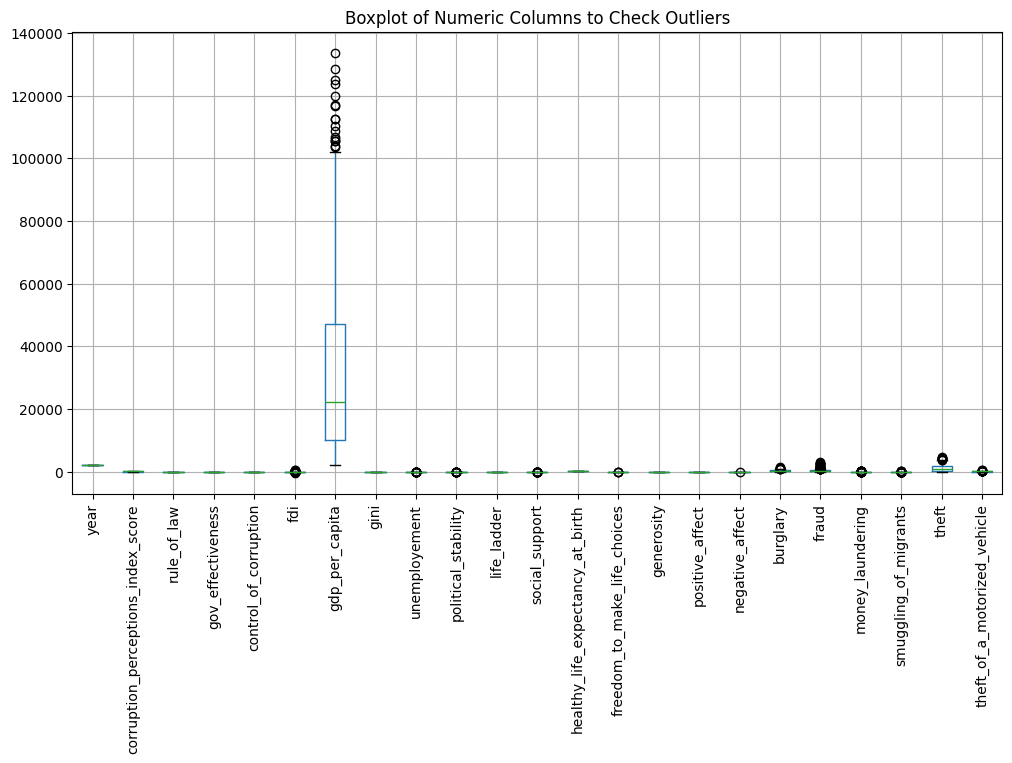

In [518]:
# In[3]:
# Let's identify numeric columns for quick outlier checks
numeric_cols = corruption_dataset.select_dtypes(include=[np.number]).columns.tolist()

# Quick boxplot to see distribution for numeric columns
plt.figure(figsize=(12,6))
corruption_dataset.boxplot(column=numeric_cols, rot=90)
plt.title("Boxplot of Numeric Columns to Check Outliers")
plt.show()

# For missing data, we could do something like:
# df['column_name'].fillna(df['column_name'].median(), inplace=True)
# or handle it later in a pipeline with SimpleImputer.


Correlation with CPI Score:
 corruption_perceptions_index_score    1.000000
control_of_corruption                 0.990316
rule_of_law                           0.953324
gov_effectiveness                     0.944440
life_ladder                           0.820737
positive_affect                       0.811385
gdp_per_capita                        0.809550
theft                                 0.761408
healthy_life_expectancy_at_birth      0.721411
political_stability                   0.710800
freedom_to_make_life_choices          0.704216
burglary                              0.547091
fraud                                 0.529688
social_support                        0.465392
generosity                            0.433704
theft_of_a_motorized_vehicle          0.329528
money_laundering                      0.307609
year                                  0.000466
fdi                                  -0.002289
smuggling_of_migrants                -0.009600
gini                           

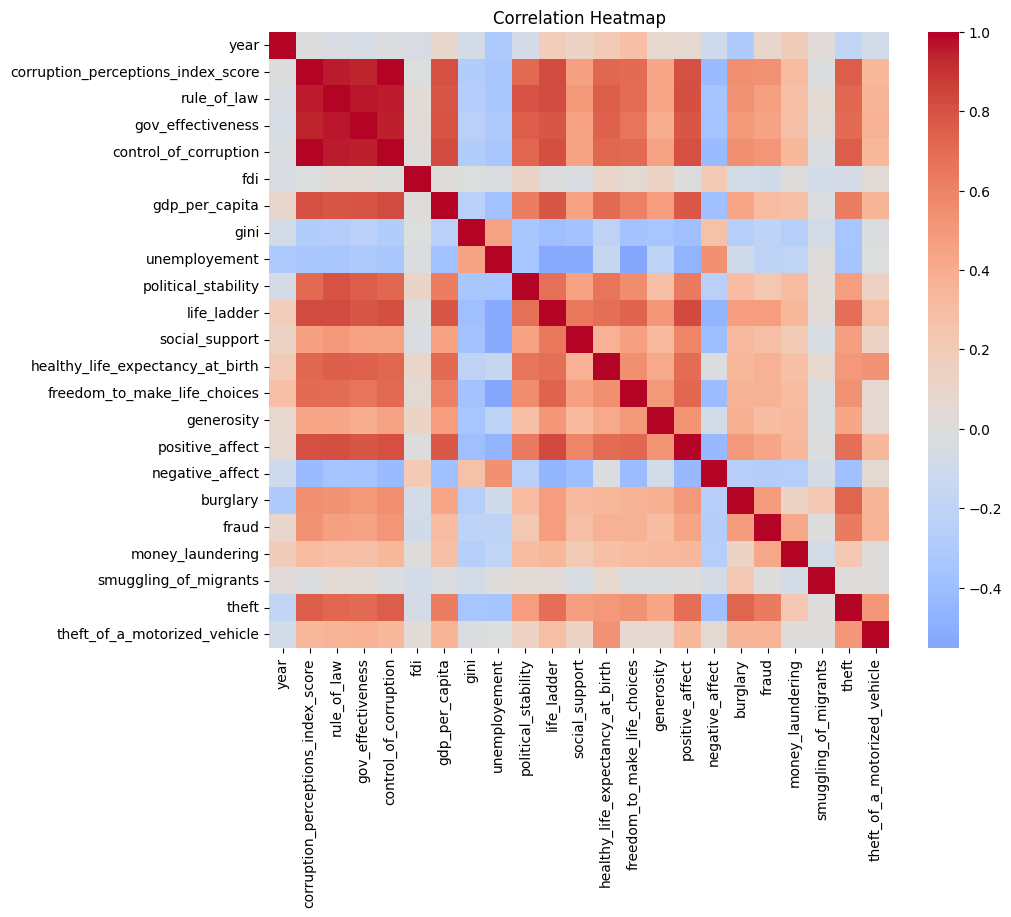

In [519]:
# In[4]:
# Correlation matrix
corr_matrix = corruption_dataset.corr(numeric_only=True)
# Sort correlation of each feature with the target
target_corr = corr_matrix['corruption_perceptions_index_score'].sort_values(ascending=False)
print("Correlation with CPI Score:\n", target_corr)

# Let's visualize the full correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


## 5. Model the Data


### 5.1 Split the data

In [523]:
corruption_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, 0 to 503
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   iso3_code                           504 non-null    object 
 1   country                             504 non-null    object 
 2   year                                504 non-null    int64  
 3   corruption_perceptions_index_score  504 non-null    float64
 4   rule_of_law                         504 non-null    float64
 5   gov_effectiveness                   504 non-null    float64
 6   control_of_corruption               504 non-null    float64
 7   fdi                                 504 non-null    float64
 8   gdp_per_capita                      504 non-null    float64
 9   gini                                504 non-null    float64
 10  unemployement                       504 non-null    float64
 11  political_stability                 504 non-null  

In [525]:
columns_to_remove = ["iso3_code", "country"]

In [526]:
# Create feature set X and target y
X = corruption_dataset.drop(columns=columns_to_remove, errors='ignore')  # 'errors=ignore' handles columns that may not exist
y = corruption_dataset["corruption_perceptions_index_score"].values  # Our target

### 5.2 Train/Test Split and Pipeline Setup

- **Split** the data into training and testing sets.
- Create a **Pipeline** that:
  1. **Imputes** missing numeric values.
  2. **Scales** the numeric features.
  3. Fits a **RandomForestRegressor**.

We’ll then do a **GridSearchCV** to find the best hyperparameters for `n_estimators`, `max_depth`, and `min_samples_split`.


In [527]:
# In[6]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Define a pipeline with
# 1) Imputer (mean)
# 2) Standard Scaler
# 3) Random Forest Regressor
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define parameter grid for GridSearch
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the GridSearch on the training set
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score (MSE):", grid_search.best_score_)


Best Params: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best Score (MSE): -0.16816257232356727


# First Results: Predicting Corruption in European Countries

## Overview
Our initial analysis aimed to identify characteristics of European countries that predict corruption, using the Corruption Perceptions Index (CPI). With data from 42 countries and no missing entries, we built a Random Forest model with the following best parameters:
- **Best Params:** `max_depth=None`, `min_samples_split=2`, `n_estimators=100`
- **Best Score (MSE):** -0.168

## Key Observations
- **Strong Correlations:** Features like **control of corruption (0.99)**, **rule of law (0.95)**, and **government effectiveness (0.94)** are highly correlated with CPI. However, these correlations may stem from how CPI itself is calculated—potentially making them redundant predictors.
- **Data Completeness:** While the core CPI data is intact, some key features, like **crime rates** and **happiness metrics**, have significant gaps (~35–144 missing entries), reducing their influence.

## Limitations
1. **Feature Overlap:** CPI may already incorporate elements of features like **control of corruption**, inflating correlations and limiting the model’s insights.
2. **Missing Data:** Gaps in variables like crime undermine the diversity of predictors and reduce reliability.
3. **Model Complexity:** While Random Forest provides decent results, its ability to explain causation is limited.

## Next Steps
We’ll refine feature selection, explore alternative models (e.g., XGBoost), and focus on disentangling overlapping variables to produce more meaningful insights. So far, the results are a good start but far from definitive.


## 6. Communicate and Visualize the Results / Is the Question answered? Why?

* What questions did you ask of the data? 
* Why were these good questions? 
* What were the answers to these questions? 
* How did you obtain them? 
* Do the answers make sense? 
* Were there any difficulties in analysing the data? 
* What were the key insights obtained? 
* What are potential biases in the data and analysis? 
* hich Data Science tools and techniques were learned during this exercise?

• This notebook should be accompanied by a 2-page PDF document that presents a summary
of the main insights into the data obtained — this is a management summary, so
should be written in a way that is easy to understand by managers. It should also justify
why the insights obtained make sense — include diagrams. Do not try and summarise everything
that you did in the two pages – focus on the insights. Only the first two pages of
the submitted document will be read — do not add a cover page.
• Data needed by the Jupyter notebook should either be accessed directly at its source in the
code, or included in the zip file (in the sub-directories expected in the Python code). If some
of the data is too large to include in the zip file and cannot be accessed directly within the
code, then include a file named install data.txt that includes full instructions on where
to download the data and in which sub-directories to install it so that the Python code in
the Jupyter notebook can execute.
There are various online tools for collaborating on Jupyter notebooks. One free possibility is
Kaggle Notebooks: https://www.kaggle.com/docs/notebooks
Note that 36 hours per person is foreseen for this exercise, which is around half the time
foreseen for the course (75 hours). This means that everyone should work for around a standard
working week on this exercise, so four weeks effort for a group of four. The evaluation will be based
on the expectation of a manager assigning such a task to a group of four junior data scientists for
a week. Note that this expectation is not met by submitting an overly long Jupyter notebook —
you need to demonstrate that:
• You have approached the analysis in a logical and structured way.
• You have learned some new data science tools and techniques.
• You have gained new insights into the data.

Overly long notebooks with little substance will be penalised.
Use any additional information that you wish — document which information you use in the
Jupyter notebook. If you use Large Language Models (LLMs) then add a section in the Jupyter
Notebook documenting exactly what LLMs were used for and how they were used. Releasing your
Notebook as a public Kaggle Notebook will be well received.